In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import torch 
from torch.utils.data import Dataset
import torch.nn as nn
from torch.nn import Linear, ReLU, CrossEntropyLoss, Sequential, Conv2d, MaxPool2d, Module, Softmax, BatchNorm2d, Dropout
from torch.optim import Adam

from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn import metrics

import os
from collections import Counter

1. Load the dataset 

In [2]:
#load training data (will be put in a function later)  
path = os.getcwd()
for i in range(3) :

    path = os.path.dirname(path)

path += '/data/'
train_df = pd.read_csv(path + 'train_v1.csv',index_col="seq_id")
train_df = train_df.drop(columns=['data_source'])
train_df = train_df.dropna()
train_df.head()

,protein_sequence,pH,tm
seq_id,,,
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2
4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,49.5


2. Translate Amino-acids to numbers and create a One-Channel array for each sequence

In [3]:
#add a new column that contains the length of each protein sequence (before padding)
train_df['length'] = train_df['protein_sequence'].str.len()

In [4]:
# fix max_length to be 500
max_length = 500

#drop rows that exceeds this value

train_df = train_df[train_df['length'] < max_length]



In [5]:
len(train_df)

20510

In [6]:

def encode_seq(sequence):
    alphabet = ['A', 'C', 'D', 'E', 'F', 'G','H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y'] # aa letters
    char_to_int = dict((c, i) for i, c in enumerate(alphabet)) 
    integer_encoded = [char_to_int[char] for char in sequence] #each character becomes int
    onehot_encoded = list()
    for value in integer_encoded:
        letter = [0 for _ in range(len(alphabet))] #0 for all letters
        letter[value] = 1 #modify the column corresponding to the letter to 1
        onehot_encoded.append(letter) #put in the array (1 letter = 1 array of 20 columns)
    
    ar =   np.transpose(np.array(onehot_encoded))
    zeros = np.zeros([len(alphabet),max_length - len(integer_encoded)] )
    onehot_encoded = np.concatenate((ar, zeros), axis = 1) #zero padding


    return onehot_encoded #we have all arrays, corresponding to the whole sequence


# new column with encoded sequence (apply for each sequence)
train_df['encoded_sequence'] = train_df['protein_sequence'].apply(lambda x: encode_seq(x))

In [7]:
train_df['encoded_sequence'].shape

(20510,)

In [8]:
#final dataframe 
train_df.head()

,protein_sequence,pH,tm,length,encoded_sequence
seq_id,,,,,
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7,341,"[[1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0,..."
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5,286,"[[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5,497,"[[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,..."
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2,265,"[[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,..."
5,AACFWRRTVIPKPPFRGISTTSARSTVMPAWVIDKYGKNEVLRFTQ...,7.0,48.4,380,"[[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


# Adding inverted sequences (DISCRADED) 
**Add it to report as an experiment ?**


inverted_df = train_df.copy()

#inver the protein sequence
inverted_df['protein_sequence'] = inverted_df.apply(lambda row : row['protein_sequence'][::-1],axis=1)
inverted_df['numerical_sequence'] = inverted_df.apply(lambda row : chr_to_int(row['protein_sequence']),axis=1)

# merge the original and inverted dataframes (size of dataset is doubled)
train_df = pd.concat([train_df,inverted_df],ignore_index=True)

## 3. Padding with zeros 

## add 0 to numerical_sequence to make all of them the same length
padded_train_df = train_df.copy()
padded_train_df['encoded_sequence'] = train_df.apply(lambda row : row['encoded_sequence'][:] + [0]*(max_length - row['length']),axis=1)

#Prepare dataframe to Pass to the dataloader (will be put in a function later)
padded_train_df.drop(columns=['protein_sequence'],inplace=True)
padded_train_df['y'] = padded_train_df['tm']
padded_train_df.drop(columns=['tm'],inplace=True)
padded_train_df['numerical_sequence'] = padded_train_df.apply(lambda row : np.array(row['numerical_sequence']),axis=1)

In [9]:
df = train_df.copy()

Split to train and validation sets

In [10]:
#splot padded_train_df into train and validation sets (will be put in a function later)
train_df = df.sample(frac=0.8,random_state=24)
val_df = df.drop(train_df.index)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)


In [11]:
print(len(train_df),len(val_df))

16408 4102


si met la transformation dans le dataframe : le kernel dies
Si met avant, dans le panda, les dimensions sont pas les bonnes (peut être transposer ??)

In [21]:
df

,protein_sequence,pH,tm,length,encoded_sequence
seq_id,,,,,
0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,75.7,341,"[[1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0,..."
1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,50.5,286,"[[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,40.5,497,"[[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,..."
3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,47.2,265,"[[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0,..."
5,AACFWRRTVIPKPPFRGISTTSARSTVMPAWVIDKYGKNEVLRFTQ...,7.0,48.4,380,"[[1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
...,...,...,...,...,...
31379,YWFPAEEMRTRNNVNNCFKKPAFANLLRFPQLYPFLCRADFIKVAA...,7.0,48.6,300,"[[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0,..."
31380,YYAYVVELCVSTISRTGEKGKTVVYLVAFHLFFVMFVWSYWMTIFT...,7.0,49.4,350,"[[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
31383,YYLWHKAASTVASIHESIDKSKKRDKEVSINKKDPFSVLIMGVDER...,7.0,42.1,274,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0,..."


## Create 1d conv net

1. get DataLoader from train_dl

In [10]:
class EnzymesDataset(Dataset):
 
    def __init__(self,df):
    
        # the Amino acid sequences as an int array
        sequence= df['encoded_sequence']
        # numerical : pH and length
        numerical = df.iloc[:,[1,3]].values

        # y : the target (tm)
        y=df.iloc[:,2].values

        #creta tensors from the numpy arrays
        self.x_sequence=torch.tensor(sequence)
        self.y=torch.tensor(y,dtype=torch.float32)
        self.num=torch.tensor(numerical,dtype=torch.float32)
   
 
    def __len__(self):
        return len(self.y)
   
    def __getitem__(self,idx):
        return self.x_sequence[idx],self.y[idx] , self.num[idx]


In [11]:
# hyperparameters
batch_size = 64
learning_rate = 0.001 # Suggested for Adam
num_epochs = 100


a faire : apres avoir fait one hot encoding, trouver comment mettre l'info de plusieurs channels dans le dataframe, sans qu'il mette d'erreur sur la taille. 
Voir comment mettre un tableau = 1 aa puis la longueur de la ligne = longueur totale (juste transposer ?)


class MyLoss(torch.nn.Module):
    def __init__(self, batch_size, classes):
        super(MyLoss, self).__init__()
        # define some attributes
        self.y_true_one_hot = torch.FloatTensor(batch_size, classes, length)

    def forward(self, y_pred, y_true):
        with torch.no_grad():
            self.y_true_one_hot.zero_().scatter_(1, y_true, 1) # permet one hot encoding
        # do some operations
        return loss


Or use cross entropy loss ?

In [15]:
# create pytorch dataframes
train_d = EnzymesDataset(train_df)
val_d = EnzymesDataset(val_df)


# create pytorch dataloaders
train_dl = torch.utils.data.DataLoader(train_d, batch_size=batch_size, shuffle=True)
val_dl = torch.utils.data.DataLoader(val_d, batch_size=batch_size, shuffle=True)

/tmp/ipykernel_558667/394230084.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  self.x_sequence=torch.tensor(sequence)


In [12]:
class Conv1D_OneChannel(nn.Module):

    def __init__(self):
        super().__init__()
       
        self.prot_seq_one_pooling = nn.Sequential(

            #With pooling only at the end (seen in paper)

            nn.Conv1d(20, 20,kernel_size=7, stride=1, padding=3),
            nn.ReLU(),
            

            
            nn.Conv1d(20, 32,kernel_size=5, stride=1, padding=2), 
            nn.ReLU(), 
         
            nn.AdaptiveAvgPool1d(32),
            
            nn.Conv1d(32, 64, kernel_size=5, stride=1, padding=2), 
            nn.ReLU(), 
            
            nn.AdaptiveAvgPool1d(64), #argument = output size 
            
            nn.Conv1d(64, 128, kernel_size=11, stride=1, padding=5), 
            nn.ReLU(), 
            
            
            nn.AdaptiveAvgPool1d(128),
            
            nn.Conv1d(128, 1, kernel_size=5, stride=1, padding=2), 
            nn.ReLU(), 
            
           
            
            
            
            

        )
        self.numerical = nn.Sequential(
            nn.Linear(2, 2),
            nn.ReLU(),
            nn.Dropout(),
            nn.Linear(2, 2),
            nn.ReLU(),
            
        )
        self.mlp = nn.Sequential(
            nn.Linear(130, 128),#input devrait être 32 + 64 plutôt non si on utilise MaxPoolId(2)? (était marqué 128 en input avant) Comme on fait le pooling
            nn.ReLU(),
 
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 1),
           
           
            
            
        )

    def forward(self, x,y):
        
        x = self.prot_seq_one_pooling(x.float())
       
        y = self.numerical(y)
       
        x = torch.cat((x.squeeze(1), y), 1)
      
        x = self.mlp(x)
        return x

In [25]:

model = Conv1D_OneChannel()
optimizer = Adam(model.parameters(), lr=learning_rate)
# defining the loss function
criterion = nn.MSELoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()

    


In [26]:
def Scoring(df_te, df_predicted):
    df = {
    "true": df_te['tm'],
    "predicted": df_predicted['tm']
}
    pearson = df.corr(method='pearson')
    rmse = mean_squared_error(df_te['tm'], df_predicted['tm'], squared=False)
    auc = metrics.roc_auc_score(df_te['tm'], df_predicted['tm'])
    
    print('Pearson: %.3f, RMSE %.3f, AUC: %.3f' %(pearson, rmse, auc))
    return pearson, rmse, auc

In [13]:
def train_epoch(model, optimizer, criterion, train_loader, epoch):
    model.train()
    rho = 0 
    train_loss = 0 
    for batch_idx, (seq, target,num) in enumerate(train_loader):
        if torch.cuda.is_available():
            seq = seq.cuda()
            target = target.cuda()
            num = num.cuda()
        optimizer.zero_grad()
        
        output = model(seq,num)
        loss = criterion(output.squeeze(), target)
        train_loss += loss.item()
        loss.backward()
        
        optimizer.step()
        # calculate Spearman's rank correlation coefficient
        p, _ = spearmanr(target.cpu().detach().numpy(), output.squeeze().cpu().detach().numpy())
        rho += p
    
    train_loss /= len(train_loader)
    
    if epoch % 50 == 0 :
        print(   f"Train Epoch: {epoch} " f" loss={train_loss:0.2e} " )

    rho = rho / len(train_loader)
    return train_loss , rho

In [14]:
def test_epoch(model, criterion, test_loader):
    model = model.eval()
    test_loss = 0
    rho = 0
    with torch.no_grad():
        for seq, target,num in test_loader:
            if torch.cuda.is_available():
                seq = seq.cuda()
                target = target.cuda()
                num = num.cuda()
            output = model(seq,num)
            test_loss += criterion(output.squeeze(), target).item()  # sum up batch loss
            # calculate pearson correlation 
            #pearson, rmse, auc = Scoring(target.cpu().detach(), output.cpu().detach())
            p, _ =  spearmanr(target.cpu().detach().numpy(), output.cpu().detach().numpy())
            rho += p
            

    test_loss /= len(test_loader)
    rho = rho / len(test_loader)
    print(
        f"Test set: Average loss: {test_loss:0.2e} "
    )

    return test_loss ,rho

In [15]:
from sklearn.model_selection import KFold

In [16]:

k_folds = 5
learning_rate = 1e-4
kfold = KFold(n_splits=k_folds, shuffle=True)
dataset = EnzymesDataset(df.reset_index(drop=True))
train_loss_history = []
test_loss_history = []
train_rho_history = []
test_rho_history = []
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):

    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

    # Define data loaders for training and testing data in this fold
    train_dl = torch.utils.data.DataLoader(
                      dataset, 
                      batch_size=64, sampler=train_subsampler)
    val_dl = torch.utils.data.DataLoader(
                      dataset,
                      batch_size=64, sampler=test_subsampler)

    model = Conv1D_OneChannel()
    optimizer = Adam(model.parameters(), lr=learning_rate)
    # defining the loss function
    criterion = nn.MSELoss()
    # checking if GPU is available
    if torch.cuda.is_available():
        model = model.cuda()
        criterion = criterion.cuda()
    
    for epoch in range(1, num_epochs + 1):
        train_loss , rho_train = train_epoch( model, optimizer, criterion, train_dl, epoch)
       

        
    
    
    test_loss , rho_test = test_epoch(model, criterion, val_dl)
        

    train_loss_history.append(train_loss)
    train_rho_history.append(rho_train)
    test_loss_history.append(test_loss)
    test_rho_history.append(rho_test)

    
    
    print(f'for fold {fold} : \n train_loss :  {train_loss}     test_loss : {test_loss} \n \n')
    
    
    
 


/tmp/ipykernel_558813/394230084.py:14: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:230.)
  self.x_sequence=torch.tensor(sequence)


FOLD 0
--------------------------------
Train Epoch: 50  loss=8.55e+01 
Train Epoch: 100  loss=7.23e+01 
Test set: Average loss: 7.83e+01 
for fold {fold} : 
 train_loss :  {train_loss}     test_loss : {test_loss} 
 

FOLD 1
--------------------------------
Train Epoch: 50  loss=1.64e+02 
Train Epoch: 100  loss=1.63e+02 
Test set: Average loss: 1.65e+02 
for fold {fold} : 
 train_loss :  {train_loss}     test_loss : {test_loss} 
 

FOLD 2
--------------------------------
Train Epoch: 50  loss=8.24e+01 
Train Epoch: 100  loss=7.03e+01 
Test set: Average loss: 7.79e+01 
for fold {fold} : 
 train_loss :  {train_loss}     test_loss : {test_loss} 
 

FOLD 3
--------------------------------
Train Epoch: 50  loss=8.43e+01 
Train Epoch: 100  loss=7.17e+01 
Test set: Average loss: 8.30e+01 
for fold {fold} : 
 train_loss :  {train_loss}     test_loss : {test_loss} 
 

FOLD 4
--------------------------------
Train Epoch: 50  loss=1.64e+02 
Train Epoch: 100  loss=1.64e+02 
Test set: Average loss:

In [29]:
# train and test the model (save it after each epoch)
train_loss_history = []
test_loss_history = []
train_rho_history = []
test_rho_history = []
for epoch in range(1, num_epochs + 1):
    train_loss , rho_train = train_epoch(
        model, optimizer, criterion, train_dl, epoch
    )
    train_loss_history.append(train_loss)
    train_rho_history.append(rho_train)

    
    
    test_loss , rho_test = test_epoch(model, criterion, val_dl)
    test_loss_history.append(test_loss)
    test_rho_history.append(rho_test)
    
    #torch.save(model.state_dict(), f"2-Conv1d_OneHot_model_{epoch}.pth")


Train Epoch: 1batch_loss=3.87e+02 
Test set: Average loss: 1.29e+02 
Train Epoch: 2batch_loss=1.25e+02 
Test set: Average loss: 1.35e+02 
Train Epoch: 3batch_loss=1.21e+02 
Test set: Average loss: 1.17e+02 
Train Epoch: 4batch_loss=1.18e+02 
Test set: Average loss: 1.10e+02 
Train Epoch: 5batch_loss=1.15e+02 
Test set: Average loss: 1.07e+02 
Train Epoch: 6batch_loss=1.08e+02 
Test set: Average loss: 1.06e+02 
Train Epoch: 7batch_loss=1.08e+02 
Test set: Average loss: 1.14e+02 
Train Epoch: 8batch_loss=1.01e+02 
Test set: Average loss: 1.05e+02 
Train Epoch: 9batch_loss=9.67e+01 
Test set: Average loss: 9.94e+01 
Train Epoch: 10batch_loss=9.57e+01 
Test set: Average loss: 9.32e+01 
Train Epoch: 11batch_loss=9.15e+01 
Test set: Average loss: 9.17e+01 
Train Epoch: 12batch_loss=8.98e+01 
Test set: Average loss: 9.27e+01 
Train Epoch: 13batch_loss=8.86e+01 
Test set: Average loss: 9.80e+01 
Train Epoch: 14batch_loss=8.55e+01 
Test set: Average loss: 9.37e+01 
Train Epoch: 15batch_loss=8.3

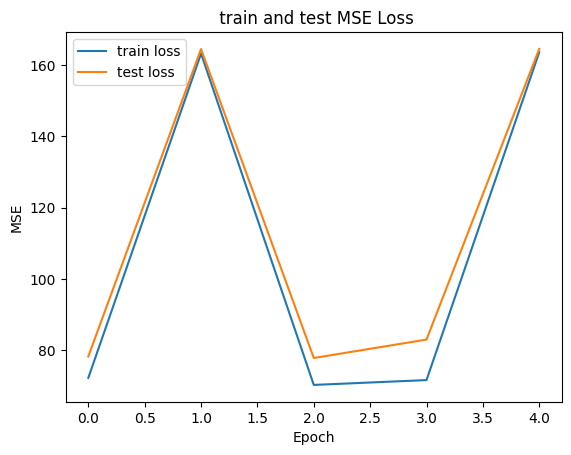

In [17]:
#create loss plot

plt.plot(train_loss_history, label='train loss')
plt.plot(test_loss_history, label='test loss')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.title(' train and test MSE Loss')
plt.legend()
#plt.savefig('2-conv1d_OneHot-Loss-2pool.png')


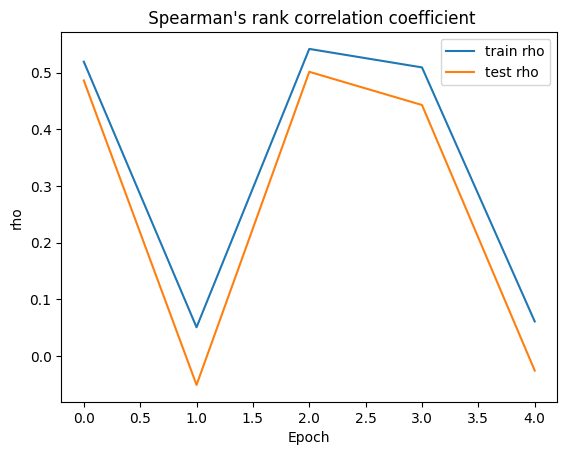

In [18]:
plt.plot(train_rho_history, label='train rho')
plt.plot(test_rho_history, label='test rho')
plt.xlabel('Epoch')
plt.ylabel('rho')
plt.title(' Spearman\'s rank correlation coefficient')
plt.legend()
#plt.savefig('2-conv1d_OneHot-rho-2pool.png')

In [ ]:
rescale data
increase the number of epochs


In [ ]:
import os
import torch
from torch import nn

from torch.utils.data import DataLoader
from sklearn.model_selection import KFold

def reset_weights(m):
    '''
    Try resetting model weights to avoid
    weight leakage.
    '''
    for layer in m.children():
        if hasattr(layer, 'reset_parameters'):
            print(f'Reset trainable parameters of layer = {layer}')
        layer.reset_parameters()


  
  


k_folds = 5
num_epochs = 100

# For fold results
results = {}

# Set fixed random number seed
torch.manual_seed(42)


dataset = EnzymesDataset(df)

# Define the K-fold Cross Validator
kfold = KFold(n_splits=k_folds, shuffle=True)

# Start print
print('--------------------------------')

# K-fold Cross Validation model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(dataset)):

    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')

    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)

    # Define data loaders for training and testing data in this fold
    trainloader = torch.utils.data.DataLoader(
                      dataset, 
                      batch_size=64, sampler=train_subsampler)
    testloader = torch.utils.data.DataLoader(
                      dataset,
                      batch_size=64, sampler=test_subsampler)

    # Init the neural network
    network = Conv1D_OneChannel()
    network.apply(reset_weights)

    # Initialize optimizer
    optimizer = torch.optim.Adam(network.parameters(), lr=1e-4)

    # Run the training loop for defined number of epochs
    for epoch in range(0, num_epochs):

        # Print epoch
        print(f'Starting epoch {epoch+1}')

        # Set current loss value
        current_loss = 0.0

        # Iterate over the DataLoader for training data
        for i, data in enumerate(trainloader, 0):

        # Get inputs
        seq, target , num = data

        # Zero the gradients
        optimizer.zero_grad()

        # Perform forward pass
        outputs = network(seq,num)

        # Compute loss
        loss = loss_function(outputs, targets)

        # Perform backward pass
        loss.backward()

        # Perform optimization
        optimizer.step()

        # Print statistics
        current_loss += loss.item()
        if i % 500 == 499:
            print('Loss after mini-batch %5d: %.3f' %
                  (i + 1, current_loss / 500))
            current_loss = 0.0

    # Process is complete.
    print('Training process has finished. Saving trained model.')

    # Print about testing
    print('Starting testing')

    # Saving the model
    save_path = f'./model-fold-{fold}.pth'
    torch.save(network.state_dict(), save_path)

    # Evaluationfor this fold
    correct, total = 0, 0
    with torch.no_grad():

      # Iterate over the test data and generate predictions
      for i, data in enumerate(testloader, 0):

        # Get inputs
        inputs, targets = data

        # Generate outputs
        outputs = network(inputs)

        # Set total and correct
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()

      # Print accuracy
      print('Accuracy for fold %d: %d %%' % (fold, 100.0 * correct / total))
      print('--------------------------------')
      results[fold] = 100.0 * (correct / total)

# Print fold results
print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
print('--------------------------------')
sum = 0.0
for key, value in results.items():
print(f'Fold {key}: {value} %')
sum += value
print(f'Average: {sum/len(results.items())} %')

ModuleNotFoundError: No module named 'torchvision'